In [330]:
import pandas as pd
import statsmodels.api as sm
import re
import numpy as np
from itertools import product

In [331]:
def remove_pattern(col_name):
    return re.sub(r'_[0-9]{3}$', '', col_name)

Zones = pd.read_excel('Zones.xlsx')
Dataset = pd.read_csv('KAG 2016-17/Agriculture/Agriculture_KAG_2016_17.csv')
Dataset.columns = map(remove_pattern, Dataset.columns)

param = pd.read_csv('Params/3_Param_Maize_Multicollinearity.csv')

Working_Directory = pd.read_csv('Working_Directory.csv')
Working_Directory = Working_Directory[['District','Maize_Production','TotalNPK', 'SowingSeedsDistributed_Maize',
'LivestockCensus_2012_Cattle', 'AreaUnderCereals_Maize','NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea','Maize_Ratio']].copy()

for x in param.columns:
    if(x != 'SowingSeedsDistributed_Maize' and x != 'AreaUnderCereals_Maize'):
        Working_Directory[x] = Working_Directory[x]*Working_Directory['Maize_Ratio']
        
Working_Directory[24:]

,District,Maize_Production,TotalNPK,SowingSeedsDistributed_Maize,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea,Maize_Ratio
24,BALLARI,104045,8404.154608,2859.005,23446.847903,49869.5,75198,0.136288
25,BIDAR,2791,249.381182,24.550,2371.831678,1382.0,19908,0.010114
26,KALABURAGI,14621,710.101614,165.000,6221.617910,2634.0,48802,0.013150
27,YADGIRI,2673,368.617469,0.000,1253.317144,961.0,22035,0.004033
28,RAICHUR,723,61.547519,14.350,188.537479,2600.0,26571,0.000525
29,KOPPAL,190252,10997.550403,5292.000,38936.400172,48210.0,82552,0.149521
30,VIJAYANAGARA,104045,8404.154608,2859.005,23446.847903,49869.5,75198,0.136288


In [332]:
Case_file = pd.read_csv('Params/3_Param_Maize_Multicollinearity.csv')
for x in Case_file.columns:
    Working_Directory[x] = Case_file[x]
y = Working_Directory['Maize_Production']
Case_file[:5]

,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK
0,2567.461578,1129.0,438.180210
1,25037.139270,14867.0,3036.080250
2,7729.614277,1987.0,222.225258
3,83821.593090,92194.0,10902.406570
4,85657.632090,173400.0,25702.835480


In [333]:
if(len(Case_file) < 31):
    row_24 = Case_file.iloc[24]
    halved_row_24 = row_24 / 2
    Case_file.iloc[24] = halved_row_24
    Case_file.loc[len(Case_file)] = halved_row_24

Case_file[24:]


,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK
24,23446.847900,49869.5,8404.154608
25,2371.831678,1382.0,249.381182
26,6221.617910,2634.0,710.101614
27,1253.317144,961.0,368.617469
28,188.537479,2600.0,61.547519
29,38936.400170,48210.0,10997.550400
30,23446.847900,49869.5,8404.154608


Finding the delta after removing the districts that are outliers, then for rest of the calculation we only remove the lower outliers.
We tried replacement using the Q1 and Q3 percentile methods :
1) We tried finding outliers using the lower and upper bounds, but that was giving unsatisfactory results with the partitioning.
2) We used the Q1 and Q3 values as the bounds and replaced values below and above them with Q1 and Q3 resp., this wasn't as successful as we anticipated (Percentage changes of 500% for 5% delta, 1000% for 10% delta) so we are back to the discarding method.

In [334]:
print((Working_Directory['Maize_Production'].mean()))

134853.12903225806


In [335]:
# Ensure that the index of y and Case_file are aligned
y = y.loc[Case_file.index]

# Identify rows in Case_file that have any zeros
rows_to_remove = (Case_file == 0).any(axis=1)

rows_to_remove |= Working_Directory['Maize_Production']  < 1000

rows_to_remove |= Working_Directory['Maize_Production'] > 500000

delta_O = 0.08*(Working_Directory[~rows_to_remove]['Maize_Production'].mean())

print((Working_Directory[~rows_to_remove]['Maize_Production'].mean()))

print(0.0368*(Working_Directory[~rows_to_remove]['Maize_Production'].mean()))
print(0.05*(Working_Directory[~rows_to_remove]['Maize_Production'].mean()))
print(0.08*(Working_Directory[~rows_to_remove]['Maize_Production'].mean()))

rows_to_remove = (Case_file == 0).any(axis=1)

rows_to_remove |= Working_Directory['Maize_Production']  < 1000

# rows_to_remove |= Working_Directory['Maize_Production'] > 500000

# Update Case_file and y
Case_file = Case_file[~rows_to_remove].reset_index(drop=True)
y = Working_Directory['Maize_Production'][~rows_to_remove].reset_index(drop=True)

# Verify the length of Case_file
case_file_length = len(Case_file)
print(case_file_length)

115742.80769230769
4259.335323076923
5787.140384615384
9259.424615384616
28


In [336]:
Case_file.columns

Index(['LivestockCensus_2012_Cattle', 'AreaUnderCereals_Maize', 'TotalNPK'], dtype='object')

In [337]:
Case_file =sm.add_constant(Case_file)
Case_file.head()

,const,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK
0,1.0,2567.461578,1129.0,438.180210
1,1.0,25037.139270,14867.0,3036.080250
2,1.0,7729.614277,1987.0,222.225258
3,1.0,83821.593090,92194.0,10902.406570
4,1.0,85657.632090,173400.0,25702.835480


In [338]:
# Case_file_1 = Case_file[['const','NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea','AreaUnderCereals_Maize','TotalNPK']].copy()

In [339]:
Working_Directory

,District,Maize_Production,TotalNPK,SowingSeedsDistributed_Maize,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea,Maize_Ratio
0,BENGALURU,2879,438.180210,4.450,2567.461578,1129.0,9348,0.018798
1,BENGALURU(R),42583,3036.080250,134.730,25037.139270,14867.0,20281,0.157645
2,RAMANAGARA,10450,222.225258,260.150,7729.614277,1987.0,23868,0.029741
3,CHITRADURGA,271975,10902.406570,5004.000,83821.593090,92194.0,92506,0.303824
4,DAVANAGERE,593544,25702.835480,6124.600,85657.632090,173400.0,78364,0.257947
5,KOLAR,1759,220.782906,51.500,2278.829821,640.0,20140,0.009950
6,CHIKKABALLAPURA,105491,8196.896749,3538.150,71206.945310,59377.0,50370,0.289061
7,SHIVAMOGGA,226532,10428.246260,3814.020,104722.000400,43827.0,32347,0.184215
8,TUMAKURU,66868,2746.313635,1639.850,37944.093760,24207.0,144708,0.071991
9,CHIKKAMAGALURU,61353,8156.290370,2923.790,40572.445630,25831.0,26174,0.120188


In [340]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

columns_to_standardize = ['LivestockCensus_2012_Cattle','AreaUnderCereals_Maize','TotalNPK']

Case_file_1 = Case_file[['const'] + columns_to_standardize].copy()
x_scaler = MinMaxScaler()

X_st = pd.DataFrame()
X_st['const'] = Case_file['const']
X_st[columns_to_standardize] = x_scaler.fit_transform(Case_file_1[columns_to_standardize])
# X_st[columns_to_standardize] = Case_file_1[columns_to_standardize]

y_scaler = MinMaxScaler()
y_st = pd.DataFrame()
y_st['Maize_Production'] = Working_Directory[~rows_to_remove]['Maize_Production'].reset_index(drop=True)
columns_to_standardize = ['Maize_Production']
y_st[columns_to_standardize] = y_scaler.fit_transform(y_st[columns_to_standardize])

y_st.head()

,Maize_Production
0,0.001893
1,0.068985
2,0.014686
3,0.456612
4,1.000000


In [ ]:
delta_O = 0.0368*(y_st[~rows_to_remove]['Maize_Production'].mean())
print(delta_O)

0.008603098773528068


C:\Users\manis\AppData\Local\Temp\ipykernel_30104\468593373.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [342]:
y_st

,Maize_Production
0,0.001893
1,0.068985
2,0.014686
3,0.456612
4,1.000000
5,0.000000
6,0.175287
7,0.379822
8,0.110021
9,0.100702


In [343]:
# model=sm.OLS(y,Case_file_1).fit()
# print(model.summary())
# model.params.values
# coef=model.params.values[1:]
# coef

model=sm.OLS(y_st['Maize_Production'],X_st).fit()
Case_file = X_st
print(model.summary())
model.params.values
coef=model.params.values[1:]
coef

                            OLS Regression Results                            
Dep. Variable:       Maize_Production   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     160.9
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           5.01e-16
Time:                        14:22:34   Log-Likelihood:                 39.298
No. Observations:                  28   AIC:                            -70.60
Df Residuals:                      24   BIC:                            -65.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

array([0.1542127 , 0.51921333, 0.47393693])

In [344]:
Case_file.drop('const',axis=1,inplace=True)
Case_file[:5]

,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK
0,0.008328,0.002831,0.004523
1,0.150727,0.082351,0.058569
2,0.041043,0.007797,0.000030
3,0.523267,0.529949,0.222219
4,0.534903,1.000000,0.530125


In [345]:
Case_file.loc[:,'Beta_0'] = model.params.values[0]
Case_file.loc[:,'Beta_1'] = coef[0]
Case_file.loc[:,'Beta_2'] = coef[1]
Case_file.loc[:,'Beta_3'] = coef[2]
# Case_file.loc[:,'Beta_4'] = coef[3]
# Case_file.loc[:,'Beta_5'] = coef[4]

intervals = np.arange(0, 1.1, 0.1)
# columns=['Sensitivity_SowingSeedsDistributed_Maize', 'Sensitivity_LivestockCensus_2012_Cattle' , 'Sensitivity_AreaUnderCereals_Maize', 'Sensitivity_TotalNPK','Sensitivity_NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea']

columns=['Sensitivity_LivestockCensus_2012_Cattle' , 'Sensitivity_AreaUnderCereals_Maize', 'Sensitivity_TotalNPK']
# Generate all possible combinations of elements in arr

num = len(columns)
combinations = product(intervals, repeat=len(columns))
combinations

In [346]:
alpha_df = pd.DataFrame(combinations, columns=columns)
alpha_df

,Sensitivity_LivestockCensus_2012_Cattle,Sensitivity_AreaUnderCereals_Maize,Sensitivity_TotalNPK
0,0.0,0.0,0.0
1,0.0,0.0,0.1
2,0.0,0.0,0.2
3,0.0,0.0,0.3
4,0.0,0.0,0.4
...,...,...,...
1326,1.0,1.0,0.6
1327,1.0,1.0,0.7
1328,1.0,1.0,0.8
1329,1.0,1.0,0.9


In [347]:
Case_file['key'] = 1
alpha_df['key'] = 1

# Performing the Cartesian product
result_df = pd.merge( alpha_df, Case_file, on='key').drop('key', axis=1)

print(result_df)

       Sensitivity_LivestockCensus_2012_Cattle  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
37263                                      1.0   
37264                                      1.0   
37265                                      1.0   
37266                                      1.0   
37267                                      1.0   

       Sensitivity_AreaUnderCereals_Maize  Sensitivity_TotalNPK  \
0                                     0.0                   0.0   
1                                     0.0                   0.0   
2                                     0.0                   0.0   
3                                     0.0                   0.0   
4                                     0.0                   0.0 

In [348]:
result_df.head()

,Sensitivity_LivestockCensus_2012_Cattle,Sensitivity_AreaUnderCereals_Maize,Sensitivity_TotalNPK,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK,Beta_0,Beta_1,Beta_2,Beta_3
0,0.0,0.0,0.0,0.008328,0.002831,0.004523,-0.01054,0.154213,0.519213,0.473937
1,0.0,0.0,0.0,0.150727,0.082351,0.058569,-0.01054,0.154213,0.519213,0.473937
2,0.0,0.0,0.0,0.041043,0.007797,0.000030,-0.01054,0.154213,0.519213,0.473937
3,0.0,0.0,0.0,0.523267,0.529949,0.222219,-0.01054,0.154213,0.519213,0.473937
4,0.0,0.0,0.0,0.534903,1.000000,0.530125,-0.01054,0.154213,0.519213,0.473937


In [349]:
Working_Directory['Maize_Production'].mean()

np.float64(134853.12903225806)

In [350]:
Working_Directory.columns

Index(['District', 'Maize_Production', 'TotalNPK',
       'SowingSeedsDistributed_Maize', 'LivestockCensus_2012_Cattle',
       'AreaUnderCereals_Maize',
       'NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea',
       'Maize_Ratio'],
      dtype='object')

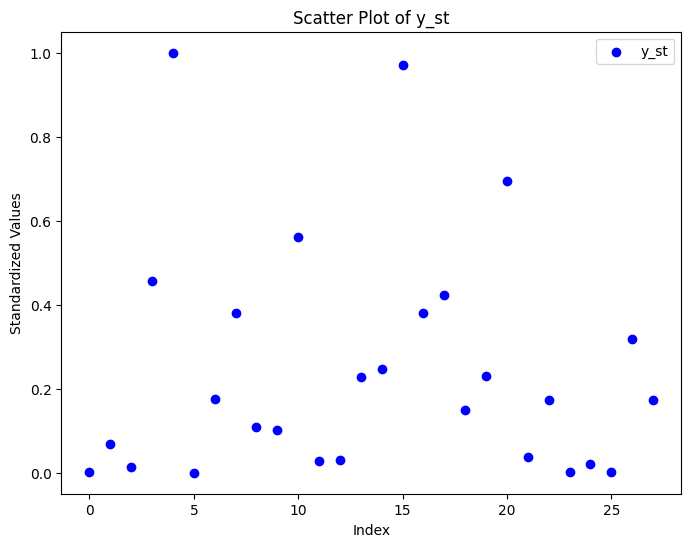

In [351]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_st)), y_st, color='blue', label='y_st')

# Adding labels and title
plt.title('Scatter Plot of y_st')
plt.xlabel('Index')
plt.ylabel('Standardized Values')

# Show legend and plot
plt.legend()
plt.show()


In [352]:
y_st

,Maize_Production
0,0.001893
1,0.068985
2,0.014686
3,0.456612
4,1.000000
5,0.000000
6,0.175287
7,0.379822
8,0.110021
9,0.100702


In [353]:
# delta_O = 0.05*(Working_Directory.drop([10])['Maize_Production'].mean())
# delta_O

In [354]:
# delta_O = 5000

# result_df['New_F1'] = result_df['SowingSeedsDistributed_Maize'] + (result_df['Sensitivity_SowingSeedsDistributed_Maize']*delta_O)/result_df['Beta_1']
result_df['New_F1'] = result_df['LivestockCensus_2012_Cattle'] + (result_df['Sensitivity_LivestockCensus_2012_Cattle']*delta_O)/result_df['Beta_1']
result_df['New_F2'] = result_df['AreaUnderCereals_Maize'] + (result_df['Sensitivity_AreaUnderCereals_Maize']*delta_O)/result_df['Beta_2']
result_df['New_F3'] = result_df['TotalNPK'] + (result_df['Sensitivity_TotalNPK']*delta_O)/result_df['Beta_3']
# result_df['New_F4'] = result_df['NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea'] + (result_df['Sensitivity_NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea']*delta_O)/result_df['Beta_4']
result_df['District'] = np.tile(Working_Directory[~rows_to_remove]['District'],11**num)

# result_df['New_F1'] = result_df['New_F1'].apply(lambda x: max(0, x))
# result_df['New_F2'] = result_df['New_F2'].apply(lambda x: max(0, x))
# result_df['New_F3'] = result_df['New_F3'].apply(lambda x: max(0, x))
# result_df['New_F4'] = result_df['New_F4'].apply(lambda x: max(0, x))
# result_df['New_F5'] = result_df['New_F5'].apply(lambda x: max(0, x))

In [355]:
result_df['New_Production'] = result_df['Beta_1'] * result_df['New_F1'] + result_df['Beta_2'] * result_df['New_F2'] + result_df['Beta_3'] * result_df['New_F3']+ result_df['Beta_0']
# + result_df['Beta_4'] * result_df['New_F4']  + result_df['Beta_5'] * result_df['New_F5'] + result_df['Beta_0']
result_df['New_Production'] = result_df['New_Production'].apply(lambda x: max(0, x))

result_df

,Sensitivity_LivestockCensus_2012_Cattle,Sensitivity_AreaUnderCereals_Maize,Sensitivity_TotalNPK,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK,Beta_0,Beta_1,Beta_2,Beta_3,New_F1,New_F2,New_F3,District,New_Production
0,0.0,0.0,0.0,0.008328,0.002831,0.004523,-0.01054,0.154213,0.519213,0.473937,0.008328,0.002831,0.004523,BENGALURU,0.000000
1,0.0,0.0,0.0,0.150727,0.082351,0.058569,-0.01054,0.154213,0.519213,0.473937,0.150727,0.082351,0.058569,BENGALURU(R),0.083220
2,0.0,0.0,0.0,0.041043,0.007797,0.000030,-0.01054,0.154213,0.519213,0.473937,0.041043,0.007797,0.000030,RAMANAGARA,0.000000
3,0.0,0.0,0.0,0.523267,0.529949,0.222219,-0.01054,0.154213,0.519213,0.473937,0.523267,0.529949,0.222219,CHITRADURGA,0.450629
4,0.0,0.0,0.0,0.534903,1.000000,0.530125,-0.01054,0.154213,0.519213,0.473937,0.534903,1.000000,0.530125,DAVANAGERE,0.842408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37263,1.0,1.0,1.0,0.007088,0.004295,0.000595,-0.01054,0.154213,0.519213,0.473937,0.062876,0.020864,0.018747,BIDAR,0.018875
37264,1.0,1.0,1.0,0.031486,0.011542,0.010180,-0.01054,0.154213,0.519213,0.473937,0.087273,0.028112,0.028332,KALABURAGI,0.030942
37265,1.0,1.0,1.0,0.000000,0.001858,0.003076,-0.01054,0.154213,0.519213,0.473937,0.055787,0.018428,0.021228,YADGIRI,0.017692
37266,1.0,1.0,1.0,0.238812,0.275353,0.224198,-0.01054,0.154213,0.519213,0.473937,0.294599,0.291923,0.242351,KOPPAL,0.301320


In [356]:
def normalize_list(lst):
    min_val = min(lst)
    max_val = max(lst)
    normalized_lst = [(x - min_val) / (max_val - min_val) for x in lst]
    return normalized_lst

In [357]:
import pandas as pd
import numpy as np

adjacency_excel = pd.read_excel('Karnataka_District_Adjacency_File.xlsx')

district_codes = sorted(set(adjacency_excel['District_Code']))

n = len(district_codes)
adj_matrix = np.zeros((n, n), dtype=int)

code_to_index = {code: idx for idx, code in enumerate(district_codes)}

for i in range(len(adjacency_excel)):
    district_code = adjacency_excel['District_Code'][i]
    neighbors = [int(num) for num in str(adjacency_excel['District_Neighbors'][i]).split(',') if num.strip().isdigit()]
    
    for neighbor in neighbors:
        adj_matrix[code_to_index[district_code]][code_to_index[neighbor]] = 1
        adj_matrix[code_to_index[neighbor]][code_to_index[district_code]] = 1  # Assuming adjacency is bidirectional

adj_matrix_df = pd.DataFrame(adj_matrix, index=district_codes, columns=district_codes)

print(adj_matrix_df)

adj_matrix_np = adj_matrix_df.to_numpy()

    1   2   3   4   5   6   7   8   9   10  ...  22  23  24  25  26  27  28  \
1    0   1   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2    1   0   1   0   0   1   1   0   1   0  ...   0   0   0   0   0   0   0   
3    1   1   0   0   0   0   0   0   1   0  ...   0   0   0   0   0   0   0   
4    0   0   0   0   1   0   0   0   1   1  ...   0   0   0   1   0   0   0   
5    0   0   0   1   0   0   0   1   0   1  ...   0   1   0   1   0   0   0   
6    0   1   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
7    0   1   0   0   0   1   0   0   1   0  ...   0   0   0   0   0   0   0   
8    0   0   0   0   1   0   0   0   0   1  ...   0   1   1   0   0   0   0   
9    0   1   1   1   0   0   1   0   0   1  ...   0   0   0   0   0   0   0   
10   0   0   0   1   1   0   0   1   1   0  ...   0   0   0   0   0   0   0   
11   0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
12   0   0   0   0   0   0   0   1   0   1  ...   0 

In [358]:
tre = pd.DataFrame()
tre['Maize_Production'] =  y_st['Maize_Production']
tre['District'] = result_df['District']
tre

,Maize_Production,District
0,0.001893,BENGALURU
1,0.068985,BENGALURU(R)
2,0.014686,RAMANAGARA
3,0.456612,CHITRADURGA
4,1.000000,DAVANAGERE
5,0.000000,KOLAR
6,0.175287,CHIKKABALLAPURA
7,0.379822,SHIVAMOGGA
8,0.110021,TUMAKURU
9,0.100702,CHIKKAMAGALURU


In [359]:
def calculate_avg_capability(capability, neighbors):
    num_neighbors = len(neighbors)
    if num_neighbors == 0:
        return 0
    sum_capabilities = sum(capability[n] for n in neighbors)
    return sum_capabilities / num_neighbors

def calculate_stress_stability(capability, adjacency_matrix):
    n = len(capability)
    stress = np.zeros(n)
    stability = np.zeros(n)
    
    for i in range(n):
        neighbors = [j for j in range(n) if adjacency_matrix[i][j] == 1 and i != j]
        if len(neighbors) > 0:
            avg_capability = calculate_avg_capability(capability, neighbors)
            stress[i] = abs(avg_capability - capability[i])
            # stability[i] = 1 - stress[i]
        else:
            stress[i] = 0  # If no neighbors, stress is zero
            # stability[i] = 1
    min_stress = min(stress)
    max_stress = max(stress)
    
    if max_stress - min_stress > 0:
        stress = (stress - min_stress) / (max_stress - min_stress)
    else:
        stress = np.zeros(n)
    
    stability = 1 - stress
        
    return stress, stability

In [360]:
stress_values_list = []
stability_values_list = []

# Define batch size
batch_size = case_file_length

# Iterate over the New_Production column in batches of 31
num_batches = len(result_df) // batch_size

for i in range(num_batches):
    # Get the batch of 31 production values
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch = result_df['New_Production'][start_idx:end_idx].values
    
    # Calculate the stress and stability values for the batch
    stress_batch, stability_batch = calculate_stress_stability(batch, adj_matrix_np)
    
    stress_values_list.extend(stress_batch)
    stability_values_list.extend(stability_batch)


print(num_batches)
print(len(stress_batch))
print(len(stress_values_list), len(stability_values_list))

result_df['Stress_Values'] = stress_values_list
result_df['Stability_Values'] = stability_values_list

1331
28
37268 37268


In [361]:
result_df.columns

Index(['Sensitivity_LivestockCensus_2012_Cattle',
       'Sensitivity_AreaUnderCereals_Maize', 'Sensitivity_TotalNPK',
       'LivestockCensus_2012_Cattle', 'AreaUnderCereals_Maize', 'TotalNPK',
       'Beta_0', 'Beta_1', 'Beta_2', 'Beta_3', 'New_F1', 'New_F2', 'New_F3',
       'District', 'New_Production', 'Stress_Values', 'Stability_Values'],
      dtype='object')

In [362]:
viz_df = result_df[['District','Sensitivity_LivestockCensus_2012_Cattle','Sensitivity_AreaUnderCereals_Maize',
                    'Sensitivity_TotalNPK',	'New_Production','Stability_Values']].copy()

# viz_df = result_df[['District','Sensitivity_SowingSeedsDistributed_Maize','Sensitivity_LivestockCensus_2012_Cattle','Sensitivity_AreaUnderCereals_Maize',
#                     'Sensitivity_TotalNPK',	'Sensitivity_NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea','New_Production','Stability_Values']].copy()

abbreviation_mapping = {
    'BENGALURU': 'BLR',
    'BENGALURU(R)': 'BLR(R)',
    'RAMANAGARA': 'RGA',
    'CHITRADURGA': 'CDA',
    'DAVANAGERE': 'DVG',
    'KOLAR': 'KLR',
    'CHIKKABALLAPURA': 'CKA',
    'SHIVAMOGGA': 'SMG',
    'TUMAKURU': 'TKR',
    'CHIKKAMAGALURU': 'CMG',
    'DAKSHINA KANNADA': 'DKA',
    'UDUPI': 'UPI',
    'HASSAN': 'HSN',
    'KODAGU': 'KDG',
    'MANDYA': 'MDY',
    'MYSURU': 'MYS',
    'CHAMARAJANAGAR': 'CNR',
    'BELAGAVI': 'BLG',
    'VIJAYAPURA': 'VJP',
    'BAGALKOT': 'BKT',
    'DHARAWAD': 'DWD',
    'GADAG': 'GDG',
    'HAVERI': 'HVR',
    'UTTARA KANNADA': 'UTK',
    'BALLARI': 'BLL',
    'BIDAR': 'BDR',
    'KALABURAGI': 'KLB',
    'YADGIRI': 'YDR',
    'RAICHUR': 'RCR',
    'KOPPAL': 'KPL',
    'VIJAYANAGARA' : 'VJN'
}

viz_df['Abbreviation'] = viz_df['District'].map(abbreviation_mapping)

legend_labels = [{'Abbreviation': abb, 'Full Form': full_form} 
                    for abb, full_form in zip(viz_df['Abbreviation'].unique(), viz_df['District'].unique())]

In [363]:
Working_Directory

,District,Maize_Production,TotalNPK,SowingSeedsDistributed_Maize,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea,Maize_Ratio
0,BENGALURU,2879,438.180210,4.450,2567.461578,1129.0,9348,0.018798
1,BENGALURU(R),42583,3036.080250,134.730,25037.139270,14867.0,20281,0.157645
2,RAMANAGARA,10450,222.225258,260.150,7729.614277,1987.0,23868,0.029741
3,CHITRADURGA,271975,10902.406570,5004.000,83821.593090,92194.0,92506,0.303824
4,DAVANAGERE,593544,25702.835480,6124.600,85657.632090,173400.0,78364,0.257947
5,KOLAR,1759,220.782906,51.500,2278.829821,640.0,20140,0.009950
6,CHIKKABALLAPURA,105491,8196.896749,3538.150,71206.945310,59377.0,50370,0.289061
7,SHIVAMOGGA,226532,10428.246260,3814.020,104722.000400,43827.0,32347,0.184215
8,TUMAKURU,66868,2746.313635,1639.850,37944.093760,24207.0,144708,0.071991
9,CHIKKAMAGALURU,61353,8156.290370,2923.790,40572.445630,25831.0,26174,0.120188


In [364]:
y = y_st['Maize_Production']

viz_df['Percentage Change'] = viz_df['New_Production'] - np.tile(y.values, len(viz_df) // case_file_length + 1)[:len(viz_df)]
for i in range(0, len(viz_df), case_file_length):
    viz_df.loc[i:i+case_file_length-1, 'Percentage Change'] = viz_df.loc[i:i+case_file_length-1, 'Percentage Change'] * 100 / y.values + 1e-9
    # viz_df.loc[i:i+case_file_length-1, 'Normalized Percentage Change'] = normalize_list(viz_df.loc[i:i+case_file_length-1, 'Percentage Change'])

viz_df['Percentage Change'] = viz_df['Percentage Change'].replace([np.inf, -np.inf], 0)

In [365]:
result_df['Percentage Change'] = viz_df['Percentage Change']

In [366]:
delta_O

np.float64(0.008603098773528068)

In [367]:
Working_Directory['Maize_Production'].quantile(0.08)

np.float64(1137.3999999999999)

In [368]:
Working_Directory['Maize_Production']

0       2879
1      42583
2      10450
3     271975
4     593544
5       1759
6     105491
7     226532
8      66868
9      61353
10         0
11       109
12    333937
13     17921
14     19387
15    137154
16    147886
17    576758
18    226327
19    251699
20     90634
21    138476
22    413487
23     24088
24    104045
25      2791
26     14621
27      2673
28       723
29    190252
30    104045
Name: Maize_Production, dtype: int64

In [369]:
Working_Directory

,District,Maize_Production,TotalNPK,SowingSeedsDistributed_Maize,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea,Maize_Ratio
0,BENGALURU,2879,438.180210,4.450,2567.461578,1129.0,9348,0.018798
1,BENGALURU(R),42583,3036.080250,134.730,25037.139270,14867.0,20281,0.157645
2,RAMANAGARA,10450,222.225258,260.150,7729.614277,1987.0,23868,0.029741
3,CHITRADURGA,271975,10902.406570,5004.000,83821.593090,92194.0,92506,0.303824
4,DAVANAGERE,593544,25702.835480,6124.600,85657.632090,173400.0,78364,0.257947
5,KOLAR,1759,220.782906,51.500,2278.829821,640.0,20140,0.009950
6,CHIKKABALLAPURA,105491,8196.896749,3538.150,71206.945310,59377.0,50370,0.289061
7,SHIVAMOGGA,226532,10428.246260,3814.020,104722.000400,43827.0,32347,0.184215
8,TUMAKURU,66868,2746.313635,1639.850,37944.093760,24207.0,144708,0.071991
9,CHIKKAMAGALURU,61353,8156.290370,2923.790,40572.445630,25831.0,26174,0.120188


In [370]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
import plotly.graph_objects as go

def update_plot(alpha1, alpha2, alpha3):
    
    tolerance = 1e-5 
    filtered_df = viz_df[
        (viz_df['Sensitivity_LivestockCensus_2012_Cattle'].between(alpha1 - tolerance, alpha1 + tolerance)) &
        (viz_df['Sensitivity_AreaUnderCereals_Maize'].between(alpha2 - tolerance, alpha2 + tolerance)) & 
        (viz_df['Sensitivity_TotalNPK'].between(alpha3 - tolerance, alpha3 + tolerance)) 
    ]

    # Create a scatter plot with filtered data
    fig = px.scatter(
        filtered_df, 
        x='Stability_Values', 
        y='Percentage Change', 
        title='Maize Percentage Change vs Stability',
        labels={'Percentage Change': 'Percentage Change', 'Stability_Values': 'Stability'},
        text='Abbreviation',
        opacity=1,
        color=filtered_df['Percentage Change'].apply(lambda val: 'red' if val < 0 else 'darkblue'),  # Conditional coloring
        color_discrete_map={'red': 'red', 'darkblue': 'darkblue'}
    )

    fig.update_traces(textposition='top center', textfont=dict(size=11))

    # Update layout to add annotations and legends
    fig.update_layout(
        annotations=[
            dict(
                x=0.5,
                y=-0.25,
                showarrow=False,
                text=f' α<sub>CT</sub>: {alpha1:.2f}, α<sub>AM</sub>: {alpha2:.2f}, α<sub>NPK</sub>: {alpha3:.2f}',
                xref="paper",
                yref="paper",
                font=dict(size=13)
            )
        ],
        legend_title_text='Districts',
        legend_title=dict(font=dict(size=12)),
    )

    # Adding custom legends with abbreviations and full forms
    legend_labels = [{'Abbreviation': abb, 'Full Form': full_form} 
                     for abb, full_form in zip(filtered_df['Abbreviation'].unique(), filtered_df['District'].unique())]

    for label in legend_labels:
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(color='darkblue'),
            name=f"{label['Abbreviation']}: {label['Full Form']}"
        ))

    # Adding average lines for stability and percentage change
    avg_stability = filtered_df['Stability_Values'].mean()
    avg_precent = filtered_df['Percentage Change'].mean()

    fig.add_shape(
        type='line',
        x0=avg_stability, y0=0, x1=avg_stability, y1=1,
        line=dict(color='black', width=1.5, dash='dash'),
        yref='paper'
    )

    fig.add_shape(
        type='line',
        x0=0, y0=avg_precent, x1=1, y1=avg_precent,
        line=dict(color='black', width=1.5, dash='dash'),
        xref='paper'
    )

    fig.add_annotation(
        x=avg_stability+0.0075,
        y=-0.07,
        text=f'Avg Stability: {avg_stability:.2f}',
        showarrow=False,
        font=dict(size=10.7),
        textangle=90  # Rotate text using textangle in annotations
    )


    fig.add_trace(go.Scatter(
        x=[0.3],
        y=[avg_precent+4.5],
        text=[f'Avg Impact: {avg_precent:.2f}'],
        mode="text",
        showlegend=False,
        textfont=dict(size=10.7)
    ))

    clear_output()

    display(fig)
    


# Creating sliders for interaction
alpha1_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description='αCT:')
alpha2_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description='αAM:')
alpha3_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description='αNPK:')

# Creating interactive plot
interactive_plot = interact(update_plot, alpha1=alpha1_slider, alpha2=alpha2_slider, alpha3=alpha3_slider)

# Create update button to trigger plot update
update_button = widgets.Button(description="Update Plot")
update_button.on_click(lambda _: update_plot(alpha1_slider.value, alpha2_slider.value, alpha3_slider.value))

# Displaying the interactive plot along with the sliders and update button
display(widgets.HBox([update_button, alpha1_slider, alpha2_slider, alpha3_slider]))
display(interactive_plot)

interactive(children=(FloatSlider(value=0.5, description='αCT:', max=1.0), FloatSlider(value=0.5, description=…

<function __main__.update_plot(alpha1, alpha2, alpha3)>

In [371]:
tolerance = 1e-5
filtered_rows = viz_df[
    (viz_df['Sensitivity_LivestockCensus_2012_Cattle'].between(0.3 - tolerance, 0.3 + tolerance)) &
    (viz_df['Sensitivity_AreaUnderCereals_Maize'].between(0.5 - tolerance, 0.5 + tolerance)) &
    (viz_df['Sensitivity_TotalNPK'].between(0.8 - tolerance, 0.8 + tolerance))
]
filtered_rows

,District,Sensitivity_LivestockCensus_2012_Cattle,Sensitivity_AreaUnderCereals_Maize,Sensitivity_TotalNPK,New_Production,Stability_Values,Abbreviation,Percentage Change
11928,BENGALURU,0.3,0.5,0.8,0.008123,0.943193,BLR,329.177559
11929,BENGALURU(R),0.3,0.5,0.8,0.096985,1.000000,BLR(R),40.589565
11930,RAMANAGARA,0.3,0.5,0.8,0.013617,0.828936,RGA,-7.280161
11931,CHITRADURGA,0.3,0.5,0.8,0.464394,0.802144,CDA,1.704310
11932,DAVANAGERE,0.3,0.5,0.8,0.856173,0.266769,DVG,-14.382710
11933,KOLAR,0.3,0.5,0.8,0.004227,0.747811,KLR,0.000000
11934,CHIKKABALLAPURA,0.3,0.5,0.8,0.326762,0.698572,CKA,86.415614
11935,SHIVAMOGGA,0.3,0.5,0.8,0.334783,0.924814,SMG,-11.858056
11936,TUMAKURU,0.3,0.5,0.8,0.134813,0.921773,TKR,22.533012
11937,CHIKKAMAGALURU,0.3,0.5,0.8,0.195603,0.816630,CMG,94.239015


In [379]:
# Denormalize properly
new_val = y_scaler.inverse_transform(filtered_rows['New_Production'].values.reshape(-1, 1)).flatten()
old_val = y_scaler.inverse_transform(y_st['Maize_Production'].values.reshape(-1, 1)).flatten()

abbreviations = filtered_rows['Abbreviation']

import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the Old Production bars
fig.add_trace(go.Bar(
    x=abbreviations,
    y=old_val,  # Now correctly using denormalized values
    name='Old Production',
    marker_color='orange'
))

# Add the New Production bars
fig.add_trace(go.Bar(
    x=abbreviations,
    y=new_val,  # Now correctly using denormalized values
    name='New Production',
    marker_color='blue'
))

# Update layout for better readability
fig.update_layout(
    title='Comparison of New and Old Maize Production (8% change in State Average Production)',
    xaxis_title='Districts',
    yaxis_title='Production Values',
    barmode='group',  # To display bars side by side
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    legend_title='Production Type'
)

# Show the figure
fig.show()


In [373]:
viz_df['New_Production'] = viz_df['New_Production'].apply(lambda x: max(0, x))
y = y_st['Maize_Production']

viz_df['Impact'] = viz_df['New_Production'] - np.tile(y.values, len(viz_df) // case_file_length + 1)[:len(viz_df)]
for i in range(0, len(viz_df), case_file_length):
    viz_df.loc[i:i+case_file_length-1, 'Impact'] = viz_df.loc[i:i+case_file_length-1, 'Impact']
    # viz_df.loc[i:i+case_file_length-1, 'Normalized Percentage Change'] = normalize_list(viz_df.loc[i:i+case_file_length-1, 'Percentage Change'])

viz_df['Impact'] = viz_df['Impact'].replace([np.inf, -np.inf], 0)

In [374]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
import plotly.graph_objects as go

def update_plot(alpha1, alpha2, alpha3):
    
    tolerance = 1e-5 
    filtered_df = viz_df[
        (viz_df['Sensitivity_LivestockCensus_2012_Cattle'].between(alpha1 - tolerance, alpha1 + tolerance)) &
        (viz_df['Sensitivity_AreaUnderCereals_Maize'].between(alpha2 - tolerance, alpha2 + tolerance)) & 
        (viz_df['Sensitivity_TotalNPK'].between(alpha3 - tolerance, alpha3 + tolerance)) 
    ]

    # Create a scatter plot with filtered data
    fig = px.scatter(
        filtered_df, 
        x='Stability_Values', 
        y='Impact', 
        title='Maize Impact vs Stability',
        labels={'Impact': 'Impact', 'Stability_Values': 'Stability'},
        text='Abbreviation',
        opacity=1,
        color=filtered_df['Impact'].apply(lambda val: 'red' if val < 0 else 'darkblue'),  # Conditional coloring
        color_discrete_map={'red': 'red', 'darkblue': 'darkblue'}
    )

    fig.update_traces(textposition='top center', textfont=dict(size=11))

    # Update layout to add annotations and legends
    fig.update_layout(
        annotations=[
            dict(
                x=0.5,
                y=-0.25,
                showarrow=False,
                text=f' α<sub>CT</sub>: {alpha1:.2f}, α<sub>AM</sub>: {alpha2:.2f}, α<sub>NPK</sub>: {alpha3:.2f}',
                xref="paper",
                yref="paper",
                font=dict(size=13)
            )
        ],
        legend_title_text='Districts',
        legend_title=dict(font=dict(size=12)),
    )

    # Adding custom legends with abbreviations and full forms
    legend_labels = [{'Abbreviation': abb, 'Full Form': full_form} 
                     for abb, full_form in zip(filtered_df['Abbreviation'].unique(), filtered_df['District'].unique())]

    for label in legend_labels:
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(color='darkblue'),
            name=f"{label['Abbreviation']}: {label['Full Form']}"
        ))

    # Adding average lines for stability and percentage change
    avg_stability = filtered_df['Stability_Values'].mean()
    avg_precent = filtered_df['Impact'].mean()

    fig.add_shape(
        type='line',
        x0=avg_stability, y0=0, x1=avg_stability, y1=1,
        line=dict(color='red', width=1.5, dash='dash'),
        yref='paper'
    )

    fig.add_shape(
        type='line',
        x0=0, y0=avg_precent, x1=1, y1=avg_precent,
        line=dict(color='red', width=1.5, dash='dash'),
        xref='paper'
    )

    # Add annotations for average values
    fig.add_trace(go.Scatter(
        x=[avg_stability],
        y=[-0.07],
        text=[f'Avg Stability: {avg_stability:.2f}'],
        mode="text",
        showlegend=False,
        textfont=dict(size=10.7)
    ))

    fig.add_trace(go.Scatter(
        x=[0.3],
        y=[avg_precent-0.04],
        text=[f'Avg Impact: {avg_precent:.2f}'],
        mode="text",
        showlegend=False,
        textfont=dict(size=10.7)
    ))

    clear_output()

    display(fig)


# Creating sliders for interaction
alpha1_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description='αCT:')
alpha2_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description='αAM:')
alpha3_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description='αNPK:')

# Creating interactive plot
interactive_plot = interact(update_plot, alpha1=alpha1_slider, alpha2=alpha2_slider, alpha3=alpha3_slider)

# Create update button to trigger plot update
update_button = widgets.Button(description="Update Plot")
update_button.on_click(lambda _: update_plot(alpha1_slider.value, alpha2_slider.value, alpha3_slider.value))

# Display the button and sliders
widgets.HBox([update_button, alpha1_slider, alpha2_slider, alpha3_slider])

interactive(children=(FloatSlider(value=0.5, description='αCT:', max=1.0), FloatSlider(value=0.5, description=…

In [375]:
result_df

,Sensitivity_LivestockCensus_2012_Cattle,Sensitivity_AreaUnderCereals_Maize,Sensitivity_TotalNPK,LivestockCensus_2012_Cattle,AreaUnderCereals_Maize,TotalNPK,Beta_0,Beta_1,Beta_2,Beta_3,New_F1,New_F2,New_F3,District,New_Production,Stress_Values,Stability_Values,Percentage Change
0,0.0,0.0,0.0,0.008328,0.002831,0.004523,-0.01054,0.154213,0.519213,0.473937,0.008328,0.002831,0.004523,BENGALURU,0.000000,0.046467,0.953533,-100.000000
1,0.0,0.0,0.0,0.150727,0.082351,0.058569,-0.01054,0.154213,0.519213,0.473937,0.150727,0.082351,0.058569,BENGALURU(R),0.083220,0.000000,1.000000,20.635872
2,0.0,0.0,0.0,0.041043,0.007797,0.000030,-0.01054,0.154213,0.519213,0.473937,0.041043,0.007797,0.000030,RAMANAGARA,0.000000,0.169156,0.830844,-100.000000
3,0.0,0.0,0.0,0.523267,0.529949,0.222219,-0.01054,0.154213,0.519213,0.473937,0.523267,0.529949,0.222219,CHITRADURGA,0.450629,0.194850,0.805150,-1.310277
4,0.0,0.0,0.0,0.534903,1.000000,0.530125,-0.01054,0.154213,0.519213,0.473937,0.534903,1.000000,0.530125,DAVANAGERE,0.842408,0.732231,0.267769,-15.759206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37263,1.0,1.0,1.0,0.007088,0.004295,0.000595,-0.01054,0.154213,0.519213,0.473937,0.062876,0.020864,0.018747,BIDAR,0.018875,0.450799,0.549201,982.332120
37264,1.0,1.0,1.0,0.031486,0.011542,0.010180,-0.01054,0.154213,0.519213,0.473937,0.087273,0.028112,0.028332,KALABURAGI,0.030942,0.468846,0.531154,42.366519
37265,1.0,1.0,1.0,0.000000,0.001858,0.003076,-0.01054,0.154213,0.519213,0.473937,0.055787,0.018428,0.021228,YADGIRI,0.017692,0.344703,0.655297,1045.483845
37266,1.0,1.0,1.0,0.238812,0.275353,0.224198,-0.01054,0.154213,0.519213,0.473937,0.294599,0.291923,0.242351,KOPPAL,0.301320,0.170481,0.829519,-5.398753


In [376]:
# result_df.to_csv('Prescriptive/Maize_Prescriptive_3.68%.csv',index=False)

In [377]:
# viz_df2 = result_df[['District','Sensitivity_SowingSeedsDistributed_Maize','Sensitivity_LivestockCensus_2012_Cattle','Sensitivity_AreaUnderCereals_Maize',
#                     'Sensitivity_TotalNPK',	'Sensitivity_NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea','New_F1','New_F2','New_F3','New_F4','New_F5']].copy()

viz_df2 = result_df[['District','Sensitivity_LivestockCensus_2012_Cattle','Sensitivity_AreaUnderCereals_Maize',
                    'Sensitivity_TotalNPK',	'New_F1','New_F2','New_F3']].copy()

viz_df2.columns

Index(['District', 'Sensitivity_LivestockCensus_2012_Cattle',
       'Sensitivity_AreaUnderCereals_Maize', 'Sensitivity_TotalNPK', 'New_F1',
       'New_F2', 'New_F3'],
      dtype='object')

In [383]:
x_new_original = x_scaler.inverse_transform(viz_df2[['New_F1', 'New_F2', 'New_F3']].values)
viz_df2[['New_F1', 'New_F2', 'New_F3']] = x_new_original


In [384]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

# Function to update the bar plot based on sensitivity sliders
def update_bar_plot(alpha1, alpha2, alpha3):
    tolerance = 1e-5
    
    # Filter the dataframe based on slider sensitivity values
    filtered_df = viz_df2[
        # (viz_df2['Sensitivity_SowingSeedsDistributed_Maize'].between(alpha1 - tolerance, alpha1 + tolerance)) &
        (viz_df2['Sensitivity_LivestockCensus_2012_Cattle'].between(alpha1 - tolerance, alpha1 + tolerance)) &
        (viz_df2['Sensitivity_AreaUnderCereals_Maize'].between(alpha2 - tolerance, alpha2 + tolerance)) & 
        (viz_df2['Sensitivity_TotalNPK'].between(alpha3 - tolerance, alpha3 + tolerance)) 
        # (viz_df2['Sensitivity_NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea'].between(alpha5 - tolerance, alpha5 + tolerance))
    ]
    
    # Define the factors and their display names
    factors = ['New_F1', 'New_F2', 'New_F3']
    # display_names = ['Seeds_Maize', 'Cattle', 'Area_Maize', 'TotalNPK', 'TubeWells']
    display_names = ['Cattle (Count)', 'Area Sown Under Maize (Ha)', 'NPK Distributed (Tonnes)']

    # Calculate mean values for the selected sensitivity group
    user_values = filtered_df[factors].mean().round()
    
    # Get the mean values for the original case where all sensitivities are zero
    # original_values = viz_df2[viz_df2[['Sensitivity_SowingSeedsDistributed_Maize_320', 'Sensitivity_LivestockCensus_2012_Cattle_354',
    #                                    'Sensitivity_AreaUnderCereals_Maize_193', 'Sensitivity_TotalNPK_315',
    #                                    'Sensitivity_NetAreaIrrigatedUnderDifferentSources_TubeWells_NetIrrigatedArea_182']].eq(0).all(axis=1)][factors].mean()

    original_values = viz_df2[viz_df2[['Sensitivity_LivestockCensus_2012_Cattle',
                                       'Sensitivity_AreaUnderCereals_Maize', 'Sensitivity_TotalNPK']].eq(0).all(axis=1)][factors].mean().round()


    # Create the bar plot with interchanged axes
    fig = go.Figure(data=[
        go.Bar(name='Original Values ', y=display_names, x=original_values, marker_color='#BAC1CC', orientation='h',text=original_values),
        go.Bar(name='Prescribed Values', y=display_names, x=user_values, marker_color='#00CC96', orientation='h',text=user_values)
    ])

    # Customize the layout
    fig.update_layout(
        title="Original vs Prescribed Values",
        yaxis_title="Factors",
        xaxis_title="Values",
        barmode='group'
    )
    
    fig.update_layout(
        annotations=[
            dict(
                x=0.5,
                y=-0.25,
                showarrow=False,
                text=f' Sensitivities: α<sub>CT</sub>: {alpha1:.2f}, α<sub>AM</sub>: {alpha2:.2f}, α<sub>NPK</sub>: {alpha3:.2f}',
                xref="paper",
                yref="paper",
                font=dict(size=13)
            )
        ],
    )

    # Clear previous output and display updated plot
    clear_output()
    display(fig)

# Creating sliders for interaction
# alpha1_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='αMS:')
alpha1_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='αCT:')
alpha2_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='αAM:')
alpha3_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='αNPK:')
# alpha5_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='αTBW:')

# Creating interactive plot
interactive_plot = interact(update_bar_plot, 
                            alpha1=alpha1_slider, 
                            alpha2=alpha2_slider, 
                            alpha3=alpha3_slider)

widgets.VBox([alpha1_slider, alpha2_slider, alpha3_slider])

interactive(children=(FloatSlider(value=0.0, description='αCT:', max=1.0), FloatSlider(value=0.0, description=…